In [1]:
from utils import sars2_genome_info, get_parent, add_syn_mut_attribute, add_mut_accumulation_attr 
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd
import requests
import math

/Users/katekistler/anaconda3/envs/ncov/lib/python3.6/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


## Figure 3: S1 substitutions are temporally clustered

##### Plotting the number of S1 substitutions accumulated at every branch along a path from root to tip of the phylogeny indicates that these mutations show some temporal structure.

#### This notebook completes the analysis for Figure 3 A and Figure 2 Supplement 1. 

Import the tree and convert to Bio Phylo format. This is a time-resolved phylogeny built from 9544 SARS-CoV-2 genomes sampled between December 2019 and May 15, 2021. The tree can be viewed at https://nextstrain.org/groups/blab/ncov/adaptive-evolution/2021-05-15

In [2]:
tree_url = 'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_2021-05-15.json'

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

Get information about genome position and length of each gene 

In [3]:
reference_gene_locations, reference_gene_codon, gene_lengths_aa = sars2_genome_info()

Add information about synonymous mutations as an attribute of nodes on the tree

In [4]:
tree = add_syn_mut_attribute(tree)

Add an attribute to each node that gives the total number of mutations accumulated between the tree root and that node (including mutations on the node). 

In [5]:
tree = add_mut_accumulation_attr(tree)

Trace the path of certain isolates through the tree and store information about mutation accumulation at each branch in the path. 

Select representative tips from 3 emerging lineages to plot mutation accumulation for Figures 3A and Figure 3 Supplement 2

In [65]:
nodes_to_plot = {'USA/ME-HETL-J3202/2021': 'B.1.1.7 (Alpha)', 
                 'Uganda/UG363/2020': 'A.23.1', 
                 'Bangladesh/BCSIR-JU-03/2021':'B.1.351 (Beta)', 
                 'USA/NE-CUMC_21130027/2021': 'B.1.617.2 (Delta)', 
                 'Argentina/INEI104453/2021': 'P.1 (Gamma)', 
                 'Uganda/UG527/2021': 'B.1.525 (Eta)', 
                 'Ecuador/NIC-INSPI-315001/2021': 'B.1.526 (Iota)', 
                 'Mexico/SEARCH-100623/2021': 'B.1.427/429 (Epsilon)', 
                 'Australia/SA0707/2021' : 'B.1.617.1 (Kappa)', 
                 'Peru/LIM-INS-1036/2021': 'C.37 (Lambda)'}

In [7]:
def trace_accumulation_on_path(nodes_to_plot):
    """
    For each specified isolate, trace the path from root to tip 
    and keep track of mutation accumulation along this path
    """
    
    plot_accumulation_s1_mutations = []

    for node in tree.find_clades(terminal=True):
        
        # trace specified isolates
        if node.name in nodes_to_plot.keys():
            
            # get the path through the tree, including this node
            node_path = get_parent(tree, node)
            
            # find the number of mutations and date of each node in the path
            for parent in node_path:

                num_date = parent.node_attrs['num_date']['value']


                s1_mutations = parent.node_attrs["s1_accumulation"]
                s2_mutations = parent.node_attrs["s2_accumulation"]
                rdrp_mutations = parent.node_attrs["rdrp_accumulation"]
                s1_syn_mutations = parent.node_attrs['s1_syn_accumulation']



                plot_accumulation_s1_mutations.append({'date': num_date, 
                                                       'num_s1_mutations': s1_mutations, 
                                                       'num_s2_mutations': s2_mutations,
                                                       'num_rdrp_mutations': rdrp_mutations,
                                                       'num_s1_syn_mutations': s1_syn_mutations,
                                                       'isolate': node.name})


    df = pd.DataFrame(plot_accumulation_s1_mutations)
    
    return df

Now plot the accumulation of S1 nonsynonymous, S1 synonymous and RdRp nonsynonymous mutations along one of these paths.

This representative path is used in Figure 3A to diagram how wait times are calculated

In [8]:
def make_fig_3a(filename=None): 
    """
    Plot the accumulation of S1 nonsynonymous, S1 synonymous and 
    RdRp nonsynonymous mutations for 'USA/ME-HETL-J3202/2021'
    """
    df = trace_accumulation_on_path(nodes_to_plot)
    
    df_subset = df[df['isolate']=='USA/ME-HETL-J3202/2021']

    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,2), sharey=True)
    ax1.set_yticks([0,2,4,6,8,10])

    plt.tight_layout()
    sns.set_style('white')


    ax1 = sns.lineplot(data=df_subset, x='date', y='num_s1_mutations', 
                 color="#4770eb", ax=ax1, legend=False)
    ax1 = sns.scatterplot(data=df_subset, x='date', y='num_s1_mutations', 
                    color="#4770eb", ax=ax1, legend=False)
    
    ax2 = sns.lineplot(data=df_subset, x='date', y='num_s1_syn_mutations', 
                 color="#5094e3", ax=ax2, legend=False)
    ax2 = sns.scatterplot(data=df_subset, x='date', y='num_s1_syn_mutations', 
                    color="#5094e3", ax=ax2, legend=False)

    ax3 = sns.lineplot(data=df_subset, x='date', y='num_rdrp_mutations', 
                 color="#ff8c3a", ax=ax3, legend=False)
    ax3 = sns.scatterplot(data=df_subset, x='date', y='num_rdrp_mutations', 
                    color="#ff8c3a", ax=ax3, legend=False)

    ax1.set_title('S1 nonsynonymous', fontsize = 18)
    ax1.set_ylabel('Number of \nmutations', fontsize = 16)
    ax1.set_xlabel('')

    ax2.set_title('S1 synonymous', fontsize = 18)
    ax2.set_ylabel('')
    ax2.set_xlabel('')

    ax3.set_title('RdRp nonsynonymous', fontsize = 18)
    ax3.set_ylabel('')
    ax3.set_xlabel('')
    
    sns.despine(left=False, bottom=False)


    for ax in [ax1, ax2, ax3]:
        ax.tick_params(axis='y', which='major', labelsize=14)
        ax.tick_params(axis='x', which='major', labelsize=10)
        ax.ticklabel_format(style='plain', axis='x',useOffset=False)



    plt.figtext(-0.03, 0.99, 'A', fontsize=24, fontweight='bold')
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')

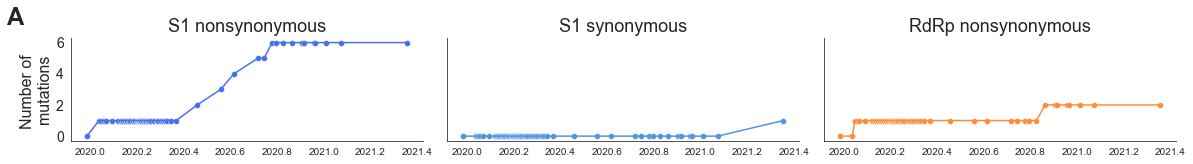

In [30]:
make_fig_3a(filename = 'plots/fig3a_20210515.png')

Plot the S1 nonsynonymous accumulation along 3 representative paths that lead to 3 different emerging lineages.

This is Figure 3 Supplement 1

In [71]:
def make_fig_3_supp(filename=None): 
    """
    Plot accumulation of S1 substitutions for 3 representative paths. 
    Label the isolate and emerging lineage it belongs to.
    """
    
    df = trace_accumulation_on_path(nodes_to_plot)
    
    # get a list of all isolate names
    isolates = list(nodes_to_plot.keys())


    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5,2, figsize=(8,6), sharex=True)
    sns.set_style('white')
    plt.tight_layout()


    # plot mutation accumulation over time for each isolate 
    ax1 = sns.lineplot(data=df[df['isolate']== isolates[0]], x='date', y='num_s1_mutations', 
                 color="#4770eb", ax=ax1, legend=False)
    ax1 = sns.scatterplot(data=df[df['isolate']== isolates[0]], x='date', y='num_s1_mutations', 
                    color="#4770eb", ax=ax1, legend=False)
    ax2 = sns.lineplot(data=df[df['isolate']== isolates[1]], x='date', y='num_s1_mutations', 
                 color="#4770eb", ax=ax2, legend=False)
    ax2 = sns.scatterplot(data=df[df['isolate']== isolates[1]], x='date', y='num_s1_mutations', 
                    color="#4770eb", ax=ax2, legend=False)
    ax3 = sns.lineplot(data=df[df['isolate']== isolates[2]], x='date', y='num_s1_mutations', 
                 color="#4770eb", ax=ax3, legend=False)
    ax3 = sns.scatterplot(data=df[df['isolate']== isolates[2]], x='date', y='num_s1_mutations', 
                    color="#4770eb", ax=ax3, legend=False)
    
    ax4 = sns.lineplot(data=df[df['isolate']== isolates[3]], x='date', y='num_s1_mutations', 
                 color="#4770eb", ax=ax4, legend=False)
    ax4 = sns.scatterplot(data=df[df['isolate']== isolates[3]], x='date', y='num_s1_mutations', 
                    color="#4770eb", ax=ax4, legend=False)
    ax5 = sns.lineplot(data=df[df['isolate']== isolates[4]], x='date', y='num_s1_mutations', 
                 color="#4770eb", ax=ax5, legend=False)
    ax5 = sns.scatterplot(data=df[df['isolate']== isolates[4]], x='date', y='num_s1_mutations', 
                    color="#4770eb", ax=ax5, legend=False)
    ax6 = sns.lineplot(data=df[df['isolate']== isolates[5]], x='date', y='num_s1_mutations', 
                 color="#4770eb", ax=ax6, legend=False)
    ax6 = sns.scatterplot(data=df[df['isolate']== isolates[5]], x='date', y='num_s1_mutations', 
                    color="#4770eb", ax=ax6, legend=False)
    ax7 = sns.lineplot(data=df[df['isolate']== isolates[6]], x='date', y='num_s1_mutations', 
                 color="#4770eb", ax=ax7, legend=False)
    ax7 = sns.scatterplot(data=df[df['isolate']== isolates[6]], x='date', y='num_s1_mutations', 
                    color="#4770eb", ax=ax7, legend=False)
    ax8 = sns.lineplot(data=df[df['isolate']== isolates[7]], x='date', y='num_s1_mutations', 
                 color="#4770eb", ax=ax8, legend=False)
    ax8 = sns.scatterplot(data=df[df['isolate']== isolates[7]], x='date', y='num_s1_mutations', 
                    color="#4770eb", ax=ax8, legend=False)
    ax9 = sns.lineplot(data=df[df['isolate']== isolates[8]], x='date', y='num_s1_mutations', 
                 color="#4770eb", ax=ax9, legend=False)
    ax9 = sns.scatterplot(data=df[df['isolate']== isolates[8]], x='date', y='num_s1_mutations', 
                    color="#4770eb", ax=ax9, legend=False)
    ax10 = sns.lineplot(data=df[df['isolate']== isolates[9]], x='date', y='num_s1_mutations', 
                 color="#4770eb", ax=ax10, legend=False)
    ax10 = sns.scatterplot(data=df[df['isolate']== isolates[9]], x='date', y='num_s1_mutations', 
                    color="#4770eb", ax=ax10, legend=False)
    
    
    for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]:
        ax.yaxis.set_major_locator(plt.MultipleLocator(2.0))
        ax.tick_params(axis='y', which='major', labelsize=12)
        ax.tick_params(axis='x', which='major', labelsize=10)
        ax.ticklabel_format(style='plain', axis='x',useOffset=False)
        ax.set_ylabel('')

    # label the isolate and emerging lineage it belongs to
    ax1.annotate(f'{isolates[0]}\n{nodes_to_plot[isolates[0]]}', xy=(0.5, 0.1),xycoords='axes fraction')
    ax2.annotate(f'{isolates[1]}\n{nodes_to_plot[isolates[1]]}', xy=(0.6, 0.1), xycoords='axes fraction')
    ax3.annotate(f'{isolates[2]}\n{nodes_to_plot[isolates[2]]}', xy=(0.5, 0.1), xycoords='axes fraction')
    ax4.annotate(f'{isolates[3]}\n{nodes_to_plot[isolates[3]]}', xy=(0.45, 0.1), xycoords='axes fraction')
    ax5.annotate(f'{isolates[4]}\n{nodes_to_plot[isolates[4]]}', xy=(0.55, 0.1), xycoords='axes fraction')
    ax6.annotate(f'{isolates[5]}\n{nodes_to_plot[isolates[5]]}', xy=(0.6, 0.1), xycoords='axes fraction')
    ax7.annotate(f'{isolates[6]}\n{nodes_to_plot[isolates[6]]}', xy=(0.5, 0.1), xycoords='axes fraction')
    ax8.annotate(f'{isolates[7]}\n{nodes_to_plot[isolates[7]]}', xy=(0.5, 0.1), xycoords='axes fraction')
    ax9.annotate(f'{isolates[8]}\n{nodes_to_plot[isolates[8]]}', xy=(0.6, 0.1), xycoords='axes fraction')
    ax10.annotate(f'{isolates[9]}\n{nodes_to_plot[isolates[9]]}', xy=(0.5, 0.1), xycoords='axes fraction')

    
    ax5.set_ylabel('Number of S1 mutations', fontsize=16)
    ax9.set_xlabel('Date', fontsize=16)
    ax10.set_xlabel('Date', fontsize=16)

    sns.despine(left=False, bottom=False)
    plt.subplots_adjust(hspace=0.2, wspace=0.2)


    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')

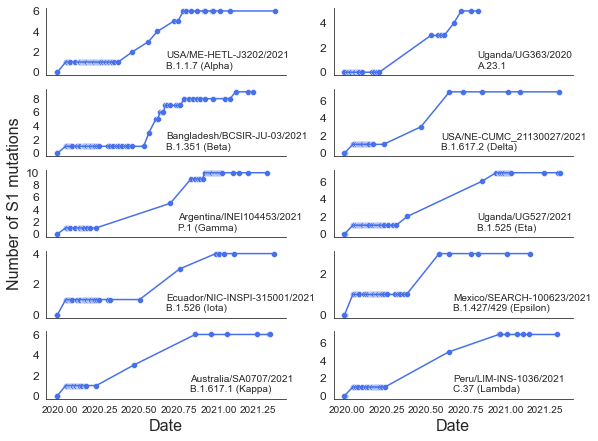

In [73]:
make_fig_3_supp(filename='plots/fig3_supp_s1accumulation.png')